# Potato Leaf

Potato Leaf Detection using Resnet

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:
# Execute this to save new versions of the notebook
jovian.commit(project="neural-pro-6")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/krish-vadhani/neural-pro-6


'https://jovian.ai/krish-vadhani/neural-pro-6'

# Importing all the libraries

In [5]:
!pip install opendatasets

In [6]:
import opendatasets as od
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split,DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

# Downloading the dataset

In [7]:
dataset_url = 'https://www.kaggle.com/abbasataiemontazer/potato-leaf'

In [8]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: krishvadhani
Your Kaggle Key: ··········


100%|██████████| 25.2M/25.2M [00:00<00:00, 154MB/s] 

In [9]:
data_dir = './potato-leaf/Potato/Train'

In [10]:
train_dataset = ImageFolder(data_dir,
                            tt.Compose([tt.CenterCrop(150),
                                        tt.Resize(150),
                                        tt.RandomHorizontalFlip(),
                                        tt.ToTensor()]))

In [11]:
val_dataset = ImageFolder('./potato-leaf/Potato/Valid',
                            tt.Compose([tt.CenterCrop(150),
                                        tt.Resize(150),
                                        tt.RandomHorizontalFlip(),
                                        tt.ToTensor()]))

In [12]:
test_dataset = ImageFolder('./potato-leaf/Potato/Test',
                            tt.Compose([tt.CenterCrop(150),
                                        tt.Resize(150),
                                        tt.RandomHorizontalFlip(),
                                        tt.ToTensor()]))

# Creating DataLoader

In [13]:
train_dl = DataLoader(train_dataset,32,shuffle=True,num_workers=2,pin_memory=True)

In [14]:
val_dl = DataLoader(val_dataset,32,num_workers=2,pin_memory=True)

In [15]:
test_dl = DataLoader(test_dataset,32,num_workers=2,pin_memory=True)

# EDA

In [16]:
def show_img(img,label):
  plt.imshow(img.permute(1,2,0))
  print('Label',train_dataset.classes[label])
  plt.axis('off')

Label Potato___Early_blight


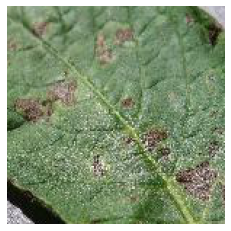

In [17]:
show_img(*train_dataset[0])

Label Potato___healthy


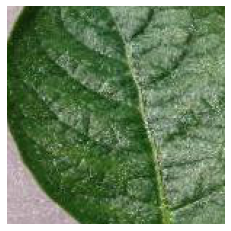

In [18]:
show_img(*train_dataset[682])

In [19]:
def show_batch(train_dl):
  for img, label in train_dl:
    plt.figure(figsize=(16,16))
    plt.imshow(make_grid(img, nrow=16).permute(1,2,0))
    plt.axis('off')
    break

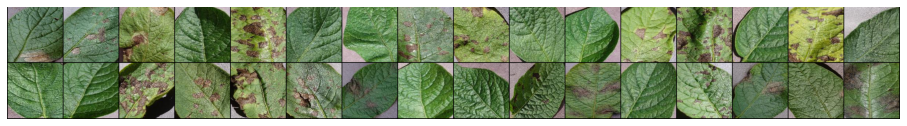

In [20]:
show_batch(train_dl)

# Training the Model

In [21]:
class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    img, label = batch
    out = self(img)
    loss = F.cross_entropy(out,label)
    return loss

  def validation_step(self,batch):
    img, label = batch
    out = self(img)
    loss = F.cross_entropy(out,label)
    acc = accuracy(out,label)
    return {'val_loss':loss,'val_acc':acc}   

  def validation_epoch_end(self,out):
    val_loss = [x['val_loss'] for x in out]
    epoch_loss = torch.stack(val_loss).mean()

    val_acc = [x['val_acc'] for x in out]
    epoch_acc = torch.stack(val_acc).mean()
    return {'val_loss':epoch_loss, 'val_acc':epoch_acc}

  def epoch_end(self,epoch,result):
    print('Epoch:[{}],val_loss:{},val_acc:{},train_loss:{}'.format(epoch,result['val_loss'],result['val_acc'],result['train_loss']))

In [22]:
def accuracy(out, label):
  _, pred = torch.max(out,dim=1)
  return torch.tensor(torch.sum(pred==label)/len(pred))

In [23]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

# Resnet 9

In [26]:
def conv_block(in_channel,out_channel,pool=False):
  layers = [nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1,stride=1),
           nn.BatchNorm2d(out_channel),
           nn.ReLU(inplace=True)]


  if pool:
    layers.append(nn.MaxPool2d(2))

  return nn.Sequential(*layers)

In [27]:
class Resnet9(ImageClassificationBase):
  def __init__(self,in_channel, num_classes):
    super().__init__()
    self.conv1 = conv_block(in_channel, 64)
    self.conv2 = conv_block(64,128,pool=True)
    self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))

    self.conv3 = conv_block(128,256,pool=True)
    self.conv4 = conv_block(256,512,pool=True)
    self.res2 = nn.Sequential(conv_block(512,512),conv_block(512,512))

    self.classifier = nn.Sequential(
        nn.MaxPool2d(4),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(512*16,num_classes)
    )

  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    out = self.classifier(out)

    return out

In [28]:
model = to_device(Resnet9(3,3),device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [29]:
@torch.no_grad()
def evaluate(model,val_dl):
  model.eval()
  out = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(out)

In [30]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [31]:
def fit(epochs,model,max_lr,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(),max_lr)
    history = []
    torch.cuda.empty_cache()

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        train_loss = []
        model.train()
        lrs = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model,val_dl)
        result['train_loss'] = torch.stack(train_loss).mean()
        result['lrs'] = lrs
        model.epoch_end(epoch,result)
        history.append(result)

    return history

In [32]:
hist = [evaluate(model, val_dl)]
hist

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


[{'val_acc': tensor(0.3125, device='cuda:0'),
  'val_loss': tensor(1.1006, device='cuda:0')}]

In [33]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam    

In [34]:
hist += fit(epochs,model,1e-2,train_dl,val_dl,weight_decay=weight_decay,opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:[0],val_loss:3.131643056869507,val_acc:0.637499988079071,train_loss:1.2150670289993286
Epoch:[1],val_loss:67.47826385498047,val_acc:0.3125,train_loss:1.931511402130127
Epoch:[2],val_loss:5.470030307769775,val_acc:0.484375,train_loss:2.5197854042053223
Epoch:[3],val_loss:16.187213897705078,val_acc:0.5177083611488342,train_loss:3.2131545543670654
Epoch:[4],val_loss:0.580421507358551,val_acc:0.815625011920929,train_loss:4.276916027069092
Epoch:[5],val_loss:1.5000221729278564,val_acc:0.6343750357627869,train_loss:3.217886209487915
Epoch:[6],val_loss:0.7888318300247192,val_acc:0.8687500357627869,train_loss:1.5452420711517334
Epoch:[7],val_loss:0.5665177702903748,val_acc:0.875,train_loss:0.9533839821815491
Epoch:[8],val_loss:0.5617884397506714,val_acc:0.8812500238418579,train_loss:1.8078497648239136
Epoch:[9],val_loss:0.3123665452003479,val_acc:0.8968750238418579,train_loss:0.881324827671051


In [36]:
hist += fit(5,model,1e-4,train_dl,val_dl,weight_decay=weight_decay,opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:[0],val_loss:0.4583963453769684,val_acc:0.887499988079071,train_loss:1.7058452367782593
Epoch:[1],val_loss:0.38478732109069824,val_acc:0.903124988079071,train_loss:0.28824642300605774
Epoch:[2],val_loss:0.4390283524990082,val_acc:0.887499988079071,train_loss:0.7231898903846741
Epoch:[3],val_loss:0.5165084004402161,val_acc:0.9000000357627869,train_loss:1.6284005641937256
Epoch:[4],val_loss:0.37462320923805237,val_acc:0.8843750357627869,train_loss:1.8685699701309204


In [37]:
hist += fit(5,model,1e-4,train_dl,val_dl,weight_decay=weight_decay,opt_func=torch.optim.SGD)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:[0],val_loss:0.40220314264297485,val_acc:0.8843750357627869,train_loss:0.8735975623130798
Epoch:[1],val_loss:0.26903316378593445,val_acc:0.8968750238418579,train_loss:0.7453488707542419
Epoch:[2],val_loss:0.2551075518131256,val_acc:0.909375011920929,train_loss:0.5565597414970398
Epoch:[3],val_loss:0.42651984095573425,val_acc:0.8968750238418579,train_loss:1.3445532321929932
Epoch:[4],val_loss:0.39075836539268494,val_acc:0.9000000357627869,train_loss:1.1316044330596924


Getting an accuracy approximately 90%

In [38]:
def plot_accuracy(history):
  acc = [x['val_acc'] for x in history]
  plt.plot(acc,'-rx')
  plt.legend(['Accuracy'])
  plt.xlabel = 'epoch'
  plt.ylabel = 'Accuracy'
  plt.title = 'Accuracy Vs Epoch'

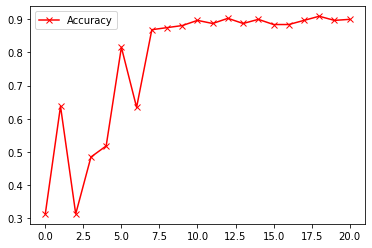

In [40]:
plot_accuracy(hist)

In [44]:
def plot_losses(history):
  val_loss = [x['val_loss'] for x in history]
  plt.plot(val_loss,'-rx')
  train_loss = [x.get('train_loss') for x in history]
  plt.plot(train_loss,'-b*')
  plt.legend(['Val Losses', 'Train Loss'])
  plt.xlabel = 'Epoch'
  plt.ylabel = 'Losses'
  plt.title = 'Losses Vs Epoch'

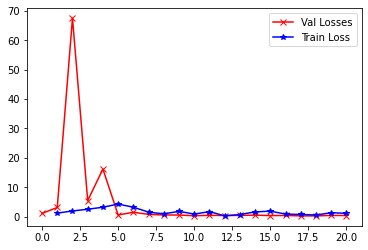

In [45]:
plot_losses(hist)